In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from matplotlib.pylab import rcParams
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima_model import ARIMA, ARMA
from statsmodels.tsa.stattools import acf, pacf

import xgboost as xgb
from xgboost import plot_importance
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import warnings

import datetime
warnings.filterwarnings('ignore')
path = "D:/program/program1/Cargo_forecast/dot_data_all/"
print(os.listdir(path))

['20181207dot1.xlsx', '20181207_莉娜_点部#1.xlsx', '20181207_莉娜_点部#2.xlsx', '20181207_莉娜_点部#3.xlsx', '20190103_1.csv', '20190103_2.csv', '20190103_点部取货量_1.xlsx', '20190103_点部取货量_2.xlsx', '20190103_点部派货量_1.xlsx', '20190103_点部派货量_2.xlsx', 'accurate.xlsx', 'comments.txt', 'dot_result.csv', 'dot_result_new.csv', 'feature_importance.png', 'rmse1.csv', 'test.csv', 'test_predict.png']


## 加载数据

In [2]:
dot_data_1 = pd.read_excel(path + '20190103_点部取货量_1.xlsx', parse_dates=[1])
dot_data_2 = pd.read_excel(path + '20190103_点部取货量_2.xlsx', parse_dates = [1])

In [3]:
dot_data = pd.concat([dot_data_1,dot_data_2],ignore_index = True)
data = dot_data.copy()
data.head()

,dot,order_date,order_num,num,jifei_weight,shiji_weight,longitude,latitude
0,13825092291,2017-05-23,1,1,1.0,1.0,NaN,NaN
1,15102680258,2017-06-06,1,1,1.0,1.0,NaN,NaN
2,ERP客户系统组,2017-06-09,1,1,3.0,3.0,NaN,NaN
3,IT采购组,2017-04-13,8,8,8.0,8.0,NaN,NaN
4,IT采购组,2017-05-03,4,5,10.0,10.0,NaN,NaN


In [4]:
data = data.drop(['num', 'jifei_weight', 'shiji_weight', 'longitude', 'latitude'], axis = 1)

In [5]:
data_ts = data.copy()
data_ts.index = pd.to_datetime(data['order_date'])
data_ts.head()

,dot,order_date,order_num
order_date,,,
2017-05-23,13825092291,2017-05-23,1
2017-06-06,15102680258,2017-06-06,1
2017-06-09,ERP客户系统组,2017-06-09,1
2017-04-13,IT采购组,2017-04-13,8
2017-05-03,IT采购组,2017-05-03,4


## 预处理

In [6]:
data_ts.sort_index(ascending = True, inplace = True)
tmp = data_ts['2017-12':]
tmp.head()

,dot,order_date,order_num
order_date,,,
2017-12-01,坂田上雪点部,2017-12-01,313
2017-12-01,嘉定城区点部,2017-12-01,20
2017-12-01,荔湾芳村二级装卸组,2017-12-01,1
2017-12-01,无锡旺庄点部,2017-12-01,58
2017-12-01,宝安机场分拨一区包车组,2017-12-01,2


In [7]:
data_count = pd.DataFrame(tmp['order_date'].groupby(tmp['dot']).count())
data_count.reset_index(inplace = True)
useful_dot_name = data_count.loc[data_count['order_date'] >= 390, ['dot']]
len(useful_dot_name)

338

In [8]:
dot_preprocessing = pd.DataFrame()
for i, dot in enumerate(useful_dot_name['dot']):
    one_dot = data.loc[data['dot'] == dot]
    one_dot = one_dot.loc[one_dot["order_date"] >= pd.to_datetime('2017-12-01')]
    num_median = np.median(one_dot['order_num'])
    ts = pd.date_range('2017-12-01', '2018-12-31')
    df_ts = pd.DataFrame(ts, columns = ['order_date'])
    df_ts['dot'] = dot
    df_ts['dot_id'] = i + 1
    merge_res = pd.merge(df_ts, one_dot, how= 'left')
#     merge_res = merge_res.loc[merge_res["order_date"] >= pd.to_datetime('2017-12-01')]
    merge_res['order_num'].fillna(num_median, inplace = True)
    if len(merge_res) >= 390:
        dot_preprocessing = pd.concat([dot_preprocessing, merge_res], axis = 0,ignore_index = True)

In [28]:
dot_preprocessing.head()

,order_date,dot,dot_id,order_num
0,2017-12-01,东丽机场点部,1,40.0
1,2017-12-02,东丽机场点部,1,36.0
2,2017-12-03,东丽机场点部,1,14.0
3,2017-12-04,东丽机场点部,1,64.0
4,2017-12-05,东丽机场点部,1,48.0


In [9]:
dot_prep = dot_preprocessing[['dot', 'dot_id', 'order_date', 'order_num']]
dot_prep['order_num'] = np.log1p(dot_prep['order_num'])
dot_prep.sort_values(by = ['order_date'], inplace = True)
dot_prep.head()

,dot,dot_id,order_date,order_num
0,东丽机场点部,1,2017-12-01,3.713572
95832,白云人和点部,243,2017-12-01,4.663439
95436,甪直联丰点部,242,2017-12-01,3.496508
95040,甪直澄北点部,241,2017-12-01,3.465736
94644,甪直昆开点部,240,2017-12-01,3.332205


## 创建特征

In [10]:
def time_feature(data):
    # 时间
    dot_prep_1 = data.copy()
    
    dot_prep_1['year'] = dot_prep_1.order_date.dt.year
    dot_prep_1['month'] = dot_prep_1.order_date.dt.month
    dot_prep_1['day'] = dot_prep_1.order_date.dt.day
    dot_prep_1['dayofweek'] = dot_prep_1.order_date.dt.dayofweek
    dot_prep_1['dayofyear'] = dot_prep_1.order_date.dt.dayofyear
    dot_prep_1['weekofyear'] = dot_prep_1.order_date.dt.weekofyear
    
    weekofsun = pd.date_range('2017-12-01', periods = round(len(dot_prep['order_date'].unique())/7), freq = 'W-SUN')
    dot_prep_1['weekofsun'] = 0
    dot_prep_1.loc[dot_prep_1['order_date'].isin(weekofsun), ['weekofsun']] = 1
    
    dot_prep_1['holidays'] = 0
    dot_prep_1.loc[dot_prep_1['order_date'].isin(
    pd.to_datetime(['2017-01-01', '2018-01-01', '2019-01-01', '2020-01-01', '2021-01-01', '2017-01-23','2017-01-24', '2017-01-25',
                    '2017-01-26','2017-01-27', '2017-01-28', '2017-01-29', '2017-01-30', '2017-01-31', '2017-02-01', '2017-02-02',
                    '2017-02-03','2017-02-04','2018-02-12', '2018-02-13',  '2018-02-14','2018-02-15', '2018-02-16', '2018-02-17', 
                    '2018-02-18', '2018-02-19', '2018-02-20', '2018-02-21','2018-02-22','2018-02-23', '2018-02-24', '2019-02-01', 
                    '2019-02-02', '2019-02-03','2019-02-04', '2019-02-05', '2019-02-06', '2019-02-07', '2019-02-08', '2019-02-09', 
                    '2019-02-10', '2019-02-11', '2019-02-12', '2019-02-13','2017-04-02', '2017-04-03', '2017-04-04', '2018-04-05', 
                    '2018-04-06', '2018-04-07', '2019-04-05', '2019-04-06', '2019-04-07','2017-05-01', '2017-05-02', '2017-05-03', 
                    '2018-05-01', '2018-05-02', '2018-05-03', '2019-05-01', '2019-05-02', '2019-05-03','2017-05-30', '2018-06-18', 
                    '2019-06-07', '2017-10-04', '2018-09-22', '2018-09-23', '2018-09-24', '2019-09-13', '2019-09-14', '2019-09-15',
                    '2017-10-01', '2017-10-02', '2017-10-03',  '2017-10-04', '2017-10-05', '2017-10-06', '2017-10-07','2018-10-01',
                    '2018-10-02', '2018-10-03', '2018-10-04', '2018-10-05', '2018-10-06', '2018-10-07', '2019-10-01', '2019-10-02', 
                    '2019-10-03', '2019-10-04', '2019-10-05', '2019-10-06', '2019-10-07'])), ['holidays']] = 1
    return dot_prep_1

def create_feature(data):
    dot_prep_1 = time_feature(data)
    dot_prep_ts = data.copy()
    dot_prep_ts.index = pd.to_datetime(dot_prep_ts['order_date'])
    
    dot_prep_2 = pd.DataFrame()
    dot_prep_3 = pd.DataFrame()
    for dot in useful_dot_name['dot']:
        dot_ts = dot_prep_ts.loc[dot_prep_ts['dot'] == dot, ['order_num']]
        dot_ts.sort_index(ascending = True, inplace = True)
        # lagging
        lagging = pd.concat([dot_ts.shift(1), dot_ts.shift(2), dot_ts.shift(3), dot_ts.shift(4), dot_ts.shift(5), dot_ts.shift(6), dot_ts.shift(7)], axis = 1)
        lagging.columns = ['lagging1', 'lagging2', 'lagging3', 'lagging4', 'lagging5', 'lagging6', 'lagging7']
        lagging['dot'] = dot
        lagging['order_date'] = dot_ts.index
        lagging.dropna(axis = 0, inplace = True)
        dot_prep_2 = pd.concat([dot_prep_2, lagging], axis = 0)
        
        # rolling
        rolling = pd.concat([dot_ts.rolling(window = 3).mean(), dot_ts.rolling(window = 5).mean(), dot_ts.rolling(window = 7).mean()], axis = 1)
        rolling.index = rolling.index + pd.DateOffset(days = 1)
        rolling.columns = ['rolling3', 'rolling5', 'rolling7']
        rolling['dot'] = dot
        rolling['order_date'] = rolling.index
        rolling.dropna(axis = 0, inplace = True)
        dot_prep_3 = pd.concat([dot_prep_3, rolling], axis = 0)
    dot_prep_2.reset_index(drop = True, inplace = True)
    dot_prep_3.reset_index(drop = True, inplace = True)
    
    # merge
    dot_prep_result_tmp = pd.merge(dot_prep_1, dot_prep_2, how = 'right', on = ['dot', 'order_date'])
    dot_prep_result = pd.merge(dot_prep_result_tmp, dot_prep_3, how = 'left', on = ['dot', 'order_date'])
    dot_prep_result.sort_values(by = 'order_date', ascending = True, inplace = True)
#     dot_prep_result.drop(['dot', 'order_date'], axis = 1, inplace = True)
    
    return dot_prep_result

In [11]:
dot_prep_feature = create_feature(dot_prep)

In [13]:
# # 统计特征
# dot_prep_sta = dot_train.copy()
# dot_prep_dayofweek = dot_prep_sta.groupby(['dot_id', 'dayofweek'])['order_num'].agg([('week_mean', np.mean), ('week_median', np.median), ('week_min', np.min), ('week_max', np.max), ('week_std', np.std)]).reset_index()
# dot_prep_day = dot_prep_sta.groupby(['dot_id', 'day'])['order_num'].agg([('day_mean', np.mean), ('day_median', np.median), ('day_min', np.min), ('day_max', np.max), ('day_std', np.std)]).reset_index()

# dot_prep_tmp = pd.merge(dot_train, dot_prep_dayofweek, on = ['dot_id', 'dayofweek'], how = 'left')
# dot_prep_stas = pd.merge(dot_prep_tmp, dot_prep_day, on = ['dot_id', 'day'], how = 'left')

# dot_test_tmp = pd.merge(dot_test, dot_prep_dayofweek, on = ['dot_id', 'dayofweek'], how = 'left')
# dot_test_stas = pd.merge(dot_test_tmp, dot_prep_day, on = ['dot_id', 'day'], how = 'left')

In [14]:
dot_prep_feature[dot_prep_feature['dot_id'] == 1].drop(['dot'], axis = 1).head(10)

,dot_id,order_date,order_num,year,month,day,dayofweek,dayofyear,weekofyear,weekofsun,...,lagging1,lagging2,lagging3,lagging4,lagging5,lagging6,lagging7,rolling3,rolling5,rolling7
248,1,2017-12-08,4.219508,2017,12,8,4,342,49,0,...,3.931826,3.988984,3.891820,4.174387,2.708050,3.610918,3.713572,3.937543,3.739013,3.717080
580,1,2017-12-09,3.871201,2017,12,9,5,343,49,0,...,4.219508,3.931826,3.988984,3.891820,4.174387,2.708050,3.610918,4.046772,4.041305,3.789356
917,1,2017-12-10,3.401197,2017,12,10,6,344,49,1,...,3.871201,4.219508,3.931826,3.988984,3.891820,4.174387,2.708050,4.007511,3.980668,3.826539
1108,1,2017-12-11,3.970292,2017,12,11,0,345,50,0,...,3.401197,3.871201,4.219508,3.931826,3.988984,3.891820,4.174387,3.830635,3.882543,3.925560
1612,1,2017-12-12,3.828641,2017,12,12,1,346,50,0,...,3.970292,3.401197,3.871201,4.219508,3.931826,3.988984,3.891820,3.747563,3.878805,3.896404
1777,1,2017-12-13,3.828641,2017,12,13,2,347,50,0,...,3.828641,3.970292,3.401197,3.871201,4.219508,3.931826,3.988984,3.733377,3.858168,3.887378
2255,1,2017-12-14,3.891820,2017,12,14,3,348,50,0,...,3.828641,3.828641,3.970292,3.401197,3.871201,4.219508,3.931826,3.875858,3.779995,3.864472
2581,1,2017-12-15,3.850148,2017,12,15,4,349,50,0,...,3.891820,3.828641,3.828641,3.970292,3.401197,3.871201,4.219508,3.849701,3.784118,3.858757
2959,1,2017-12-16,3.761200,2017,12,16,5,350,50,0,...,3.850148,3.891820,3.828641,3.828641,3.970292,3.401197,3.871201,3.856870,3.873909,3.805992
3285,1,2017-12-17,3.135494,2017,12,17,6,351,50,1,...,3.761200,3.850148,3.891820,3.828641,3.828641,3.970292,3.401197,3.834389,3.832090,3.790277


In [15]:
dot_train = dot_prep_feature[: -(30 * 338)]
dot_test = dot_prep_feature[-(30 * 338) :]

In [16]:
dot_xtrain = dot_train.drop(['order_num'], axis = 1)
dot_ytrain = dot_train['order_num']
dot_xtest = dot_test.drop(['order_num'], axis = 1)
dot_ytest = dot_test['order_num']

## 评估方法

In [17]:
def RMSE(y_test, y_pred):
    return np.sqrt(np.sum((y_test - y_pred) ** 2)/len(y_test))

def MAE(y_test, y_pred):
    return np.sum(np.abs(y_test - y_pred))/len(y_test)

## 模型训练

In [18]:
def xgboost_model(x_train, y_train):
    params = {
        "learning_rate": 0.01,
        "n_estimators": 3300,
        "max_depth": 5,
        "min_child_weight": 3,
        "gamma": 0.5,
        "subsample": 0.9,
        "colsample_bytree": 0.8,
        "silent": 1,
        "reg_alpha" : 0.05,
        "reg_lambda" : 0.05,
        "seed": 21
    }
    print("train_start : ", datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S"))
    gbm = xgb.XGBRegressor(**params)
    gbm.fit(x_train.drop(['dot', 'order_date'], axis = 1), y_train)
    print("train_end : ", datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S"))
    
    for column, importance in zip(x_train.drop(['dot', 'order_date'], axis = 1).columns, gbm.feature_importances_):
        print(column, '\t', importance)
    # plot_importance(gbm)
    # plt.savefig(path + "feature_importance.png")
    
    return gbm

In [19]:
gbm = xgboost_model(dot_xtrain, dot_ytrain)

train_start :  2019-02-18 17:50:52
train_end :  2019-02-18 17:58:34
dot_id 	 0.06428904
year 	 0.0009784152
month 	 0.015177367
day 	 0.05127134
dayofweek 	 0.05766684
dayofyear 	 0.080552205
weekofyear 	 0.007743798
weekofsun 	 0.0048085526
holidays 	 0.028624611
lagging1 	 0.09700629
lagging2 	 0.062391866
lagging3 	 0.051856007
lagging4 	 0.05205885
lagging5 	 0.061425384
lagging6 	 0.0640862
lagging7 	 0.09497786
rolling3 	 0.07384648
rolling5 	 0.05831116
rolling7 	 0.07292773


## 预测

In [21]:
def pre_feature(data, dot_name):
    x_test_tmp = pd.DataFrame()
    rolling_tmp = pd.DataFrame()
    for dot in dot_name['dot']:
        # lagging
        dot_test = data.loc[data['dot'] == dot]
        dot_test_ts = dot_test.copy()
        dot_test['lagging7'] = dot_test['lagging6']
        dot_test['lagging6'] = dot_test['lagging5']
        dot_test['lagging5'] = dot_test['lagging4']
        dot_test['lagging4'] = dot_test['lagging3']
        dot_test['lagging3'] = dot_test['lagging2']
        dot_test['lagging2'] = dot_test['lagging1']
        dot_test['lagging1'] = dot_test['order_num']

        x_test_tmp = pd.concat([x_test_tmp, dot_test])

        # rolling
        dot_test_ts.index = pd.to_datetime(dot_test_ts['order_date'])
        num_ts = dot_test_ts.loc[dot_test_ts['dot'] == dot, ['order_num']]
        rolling = pd.concat([num_ts.rolling(window = 3).mean(), num_ts.rolling(window = 5).mean(), num_ts.rolling(window = 7).mean()], axis = 1)
    #     rolling.index = rolling.index + pd.DateOffset(days = 1)
        rolling.columns = ['rolling3', 'rolling5', 'rolling7']
        rolling['dot'] = dot
        rolling['order_date'] = rolling.index
        rolling_tmp = pd.concat([rolling_tmp, rolling])

    x_test = pd.merge(x_test_tmp.drop(['rolling3', 'rolling5', 'rolling7'], axis = 1), rolling_tmp, how = 'left', on = ['dot', 'order_date'])
    x_test['order_date'] = x_test['order_date'] + pd.DateOffset(days = 1)
    x_test.dropna(axis = 0, inplace = True)
    
    return x_test

In [22]:
print("START : ", datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S"))
result_to_csv = pd.DataFrame()
org_test = dot_train.copy()
for i in range(7):
    print(i)
    x_test = pre_feature(org_test, useful_dot_name)
    last_train_date = pd.to_datetime('2018-12-01') + pd.DateOffset(days = i + 1)
    x_test = x_test.loc[x_test['order_date'] == last_train_date, ['dot', 'dot_id', 'order_date', 'lagging1', 'lagging2', 'lagging3', 'lagging4', 'lagging5', 'lagging6', 'lagging7', 'rolling3', 'rolling5', 'rolling7']]
#     x_test['order_date'] = x_test['order_date'] + pd.DateOffset(days = i)
    
    x_test = time_feature(x_test)
    x_test = x_test[['dot', 'dot_id', 'order_date', 'year', 'month', 'day', 'dayofweek', 'dayofyear', 'weekofyear', 'weekofsun', 'holidays', 'lagging1', 'lagging2', 'lagging3', 'lagging4', 'lagging5', 'lagging6', 'lagging7', 'rolling3', 'rolling5', 'rolling7']]

    y_pre = gbm.predict(x_test.drop(['dot', 'order_date'], axis = 1))
    result = pd.DataFrame({'dot' : x_test['dot'], 'order_date' : x_test['order_date'], 'order_num' : y_pre})
    result_to_csv = pd.concat([result_to_csv, result])
    x_test = pd.merge(x_test, result, on = ['dot', 'order_date'], how = 'left')
    x_test = x_test[['dot', 'dot_id', 'order_date', 'order_num', 'year', 'month', 'day', 'dayofweek', 'dayofyear', 'weekofyear', 'weekofsun', 'holidays', 'lagging1', 'lagging2', 'lagging3', 'lagging4', 'lagging5', 'lagging6', 'lagging7', 'rolling3', 'rolling5', 'rolling7']]
    
    org_test = pd.concat([org_test, x_test])
print("END : ", datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S"))

START :  2019-02-18 18:24:41
0
1
2
3
4
5
6
END :  2019-02-18 18:31:53


In [23]:
result_to_csv['order_num'] = np.expm1(result_to_csv['order_num'])
result_to_csv.head()

,dot,order_date,order_num
358,东丽机场点部,2018-12-02,50.211891
717,东升三角点部,2018-12-02,50.519485
1076,东升宝丰点部,2018-12-02,16.891859
1435,中山沙溪点部,2018-12-02,30.029428
1794,中山港义点部,2018-12-02,26.734924


In [24]:
org_data = dot_prep.copy()
org_data['order_num'] = np.expm1(org_data['order_num'])
org_data.tail()

,dot,dot_id,order_date,order_num
90287,潮汕新溪点部,228,2018-12-31,150.0
90683,潮汕汕尾点部,229,2018-12-31,71.0
91079,烟台芝罘点部,230,2018-12-31,52.0
87911,溧水禄口点部,222,2018-12-31,47.0
133847,龙岗龙东点部,338,2018-12-31,29.0


In [29]:
r1 = pd.merge(result_to_csv, org_data, on = ['dot', 'order_date'], how = 'left')
# r1.columns = ['dot', 'order_date', 'y_pre', 'dot_id', 'y_test']
# r1 = r1[['dot', 'order_date', 'dot_id', 'y_test', 'y_pre']]
r1.head()

,dot,order_date,order_num_x,dot_id,order_num_y
0,东丽机场点部,2018-12-02,50.211891,1,86.0
1,东升三角点部,2018-12-02,50.519485,2,49.0
2,东升宝丰点部,2018-12-02,16.891859,3,21.0
3,中山沙溪点部,2018-12-02,30.029428,4,38.0
4,中山港义点部,2018-12-02,26.734924,5,11.0


In [26]:
print("MAE : ", MAE(r1.y_test, r1.y_pre))
print("RMSE : ", RMSE(r1.y_test, r1.y_pre))

MAE :  22.891221385836502
RMSE :  74.84768405164796


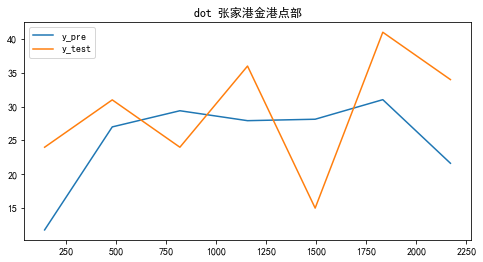

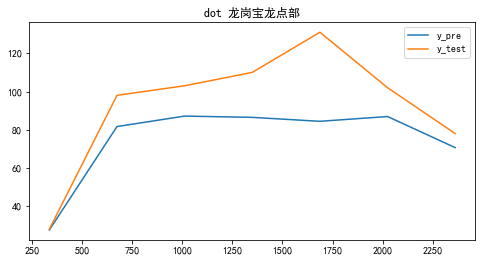

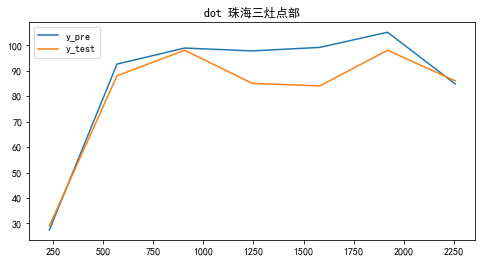

In [27]:
plt.rcParams['font.sans-serif']=['SimHei']
col_1 = ['y_pre','y_test']
L = np.random.randint( low = 0, high = 337, size = 3 )
for i in L:
    s1 = pd.DataFrame(r1[r1['dot'] == r1['dot'].unique()[i]], columns = col_1)
    s1.plot(title = 'dot {}'.format(r1['dot'].unique()[i]), figsize = (8,4))

In [ ]:
plt.rcParams['font.sans-serif']=['SimHei']
col_1 = ['y_test','y_pre']
L = np.random.randint( low = 0, high = 337, size = 3 )
for i in L:
    s1 = pd.DataFrame(result[result['dot'] == result['dot'].unique()[i]], columns = col_1)
    s1.plot(title = 'dot {}'.format(result['dot'].unique()[i]), figsize = (8,4))